Imports and setup

In [1]:
%config InteractiveShell.ast_node_interactivity="last_expr_or_assign"

In [2]:
import csv, sys
import uproot
import pandas as pd
import numpy as np
from numpy import array

np.set_printoptions(threshold=sys.maxsize)
import shap
import tensorflow as tf
import tkinter as tk
import matplotlib
import matplotlib.pyplot as plt

# don't use these in notebook mode
#from matplotlib.backends.backend_pdf import PdfPages
#matplotlib.use("PDF")
import math
import time
from math import log, sqrt
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()  # Normalized data to range from (0,1)
from sklearn.metrics import (
    precision_recall_curve,
    plot_precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc,
    roc_auc_score,
    precision_recall_curve,
    confusion_matrix
)
from datetime import datetime

# Checking if a GPU is available, not sure it will run in Jupyter
status = len(tf.config.experimental.list_physical_devices("GPU"))

# If we need a random seed.
seed = 42;

42

some useful functions

In [3]:

def plotPR(x, y, t):
    plt.subplot(411)
    plt.plot(t, x[:-1], "b--", label="Precision")
    plt.plot(t, y[:-1], "g-", label="Recall")
    plt.ylim([0.00, 1.05])
    plt.xlabel("Threshold")
    plt.title("Precision/Recall vs. Threshold Curve")
    plt.legend(loc="lower right")
    plt.grid()


def plotROC(x, y, AUC):
    plt.subplot(412)
    plt.plot(x, y, lw=1, label="ROC (area = %0.6f)" % (AUC))
    plt.plot([0, 1], [0, 1], "--", color=(0.6, 0.6, 0.6), label="Luck")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.grid()


def getZPoisson(s, b, stat, syst):
    """
    The significance for optimisation.
    s: total number of signal events
    b: total number of background events
    stat: relative MC stat uncertainty for the total bkg.
    syst: relative syst uncertainty on background
    Note that the function already accounts for the sqrt(b)
    uncertainty from the data, so we only need to pass in additional
    stat and syst terms.  e.g. the stat term above is really only
    characterizing the uncertainty due to limited MC statistics used
    to estimate the background yield.
    """
    n = s + b

    # this is a relative uncertainty
    sigma = math.sqrt(stat ** 2 + syst ** 2)

    # turn into the total uncertainty
    sigma = sigma * b

    if s <= 0 or b <= 0:
        return 0

    factor1 = 0
    factor2 = 0

    if sigma < 0.01:
        # In the limit where the total BG uncertainty is zero,
        # this reduces to approximately s/sqrt(b)
        factor1 = n * math.log((n / b))
        factor2 = n - b
    else:
        factor1 = n * math.log((n * (b + sigma ** 2)) / ((b ** 2) + n * sigma ** 2))
        factor2 = ((b ** 2) / (sigma ** 2)) * math.log(
            1 + ((sigma ** 2) * (n - b)) / (b * (b + sigma ** 2))
        )

    signif = 0
    try:
        signif = math.sqrt(2 * (factor1 - factor2))
    except ValueError:
        signif = 0

    return signif

This block defines the branch names that we'll pull from the tree.  So we'll want to edit this to update to whatever variables we're using to train the NN.

In [4]:
# Branches names of high/low level variables aka: features.
HighLevel = [
    "numjet",
    "numlep",
    "btag",
    "srap",
    "cent",
    "m_bb",
    "h_b",
    "mt1",
    "mt2",
    "mt3",
    "dr1",
    "dr2",
    "dr3",
]

### Low Level START -
type = ["flav", "pT", "eta", "phi", "b", "c"]
LeptonVAR = []
JetVAR = []
for i in range(4):
    for j in range(3):
        LeptonVAR.append("lepton" + str(j + 1) + type[i])
for i in range(1, 6):
    for j in range(10):
        JetVAR.append("jet" + str(j + 1) + type[i])
###                                               -END

# Auto select feature set.
phase = 3
if phase == 1:
    branches = sorted(HighLevel) + ["weights", "truth"]
elif phase == 2:
    branches = sorted(LeptonVAR + JetVAR) + ["weights", "truth"]
elif phase == 3:
    branches = sorted(HighLevel + JetVAR + LeptonVAR) + ["weights", "truth"]


# Number of features.
numBranches = len(branches) - 2;

75

This block reads in the data from the input files, using the branches specified above.  So we should update this section to use the right input files, etc.  Note there's also some scaling of the samples to get the weights right.

In [5]:
# Data read from file.
tree = "OutputTree"

filepath="/data/users/mhance/tthh/"

signal = uproot.open(filepath+"new_TTHH.root")[tree]
df_signal = signal.arrays(branches,library='pd')

bkgTTBB = uproot.open(filepath+"new_TTBB.root")[tree]
df_bkgTTBB = bkgTTBB.arrays(branches,library="pd")

bkgTTH = uproot.open(filepath+"new_TTH.root")[tree]
df_bkgTTH = bkgTTH.arrays(branches,library="pd")

bkgTTZ = uproot.open(filepath+"new_TTZ.root")[tree]
df_bkgTTZ = bkgTTZ.arrays(branches,library="pd")

df_background = pd.concat([df_bkgTTBB, df_bkgTTH, df_bkgTTZ])

# The 3 backgrounds are concatenated we shuffle to make sure they are not sorted.
shuffleBackground = shuffle(df_background, random_state=seed)

# Signal and shuffle background data.
rawdata = pd.concat([df_signal, shuffleBackground])

X = rawdata.drop(["weights", "truth"], axis=1)

# Normalized the data with a Gaussian distrubuition with 0 mean and unit variance.
X = sc.fit_transform(X)

# Signal
scalefactor = 0.00232 * 0.608791
sigw = rawdata["weights"][: len(signal)] * scalefactor
bkgw = rawdata["weights"][len(signal) :]

# Labeling data with 1's and 0's to distinguish.(1/positve/signal and 0/negative/background)
# Truth Labels.
y = np.concatenate((np.ones(len(df_signal)), np.zeros(len(shuffleBackground))))

# Shuffle full data and split into train/test and validation set.
X_dev, X_eval, y_dev, y_eval = train_test_split(
    X, y, test_size=0.001, random_state=seed, stratify=y
)
X_train, X_test, y_train, y_test = train_test_split(
    X_dev, y_dev, test_size=0.2, random_state=seed, stratify=y_dev
)

In [6]:
# NN model defined as a function.
def build_model(network,RATE):

    # Create a NN model. Barebones model with no layers.
    model = Sequential()

    # Best option for most NN.
    opt = keras.optimizers.Nadam()

    # Activation function other options possible.
    act = "relu"  # Relu is 0 for negative values, linear for nonzero values.

    # Use model.add() to add one layer at a time, 1st layer needs input shape, So we pass the 1st element of network.
    # Dense Layers are fully connected and most common.

    model.add(Dense(network[0], input_dim=numBranches))

    # Loop through and add layers (1,(n-2)) where n is the number of layers. We end at n-2 because we start at 1 not zero and
    # we  the input layer is added above with input dimension. Therefore we must remove 2 from layers.
    for i in range(1, len(network) - 2):
        model.add(Dense(network[i], activation=act))  # Hidden layers.
        # Turning off nuerons of layer above in loop with probability = 1-r, so r = 0.25, then 75% of nerouns are kept.
        model.add(Dropout(RATE, seed=seed))

    # Last layer needs to have one neuron for a binary classification(BC) which yields from 0 to 1.
    model.add(
        Dense(network[-1], activation="sigmoid")
    )  # Output layer's activation function for BC needs to be sigmoid.

    # Last step is compiling.
    model.compile(
        loss="binary_crossentropy",
        optimizer=opt,
        metrics=tf.keras.metrics.Precision(),
    )
    return model

In [7]:
def compare_train_test(kModel, X_train, y_train, X_test, y_test, bins=30):
    """
    This creates the signal and background distrubution.
    """
    decisions = []
    for X, y in ((X_train, y_train), (X_test, y_test)):
        d1 = model.predict(X[y > 0.5]).ravel()  # signal
        d2 = model.predict(X[y < 0.5]).ravel()  # background
        decisions += [d1, d2]
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = array([low, high])

    plt.subplot(212)
    plt.hist(
        decisions[0],
        color="r",
        alpha=0.5,
        range=low_high,
        bins=bins,
        histtype="stepfilled",
        density=True,
        label="S (train)",
    )
    plt.hist(
        decisions[1],
        color="b",
        alpha=0.5,
        range=low_high,
        bins=bins,
        histtype="stepfilled",
        density=True,
        label="B (train)",
    )

    hist, bins = np.histogram(decisions[2], bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = bins[1] - bins[0]
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt="o", c="r", label="S (test)")

    hist, bins = np.histogram(decisions[3], bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt="o", c="b", label="B (test)")

In [8]:
def runNN(LAYER, BATCH, RATE):
    """
    NN structure ex. [5,5,5,5,1] 4 layers with 5 neurons each and one output layer. LAYER value is
    the number of hidden layers excluding the output layer. Each hidden layer will contain the same
    amount of neurons (It is hard coded to be the number of features). The BATCH is the batch size,
    powers of 2 are perfered but any positive number works. RATE is the drop out rate; so a RATE = .5
    is half of the neurons being randomly turned off.
    """
    network = []
    numEpochs = 150  # Number of times the NN gets trained.
    batchSize = BATCH
    numLayers = LAYER
    neurons = numBranches

    # This creates a list that has the stucture of the NN.
    for i in range(numLayers - 1):
        network.append(neurons)
    network.append(1)
    numNeurons = sum(network)

    # This is a conformation that the script is starting and the NN structure is displayed.
    print("Script starting....\n", network)

    # This tags the output files with either GPU or CPU.
    if status == 1:
        print("GPU")
        sufix = ".GPU"
    else:
        sufix = ".CPU"
        print("CPU")

    # Start time for file name.
    startTime = datetime.now()
    pre = time.strftime("%Y.%m.%d_") + time.strftime("%H.%M.%S.")

    # Filename for keras model to be saved as.
    h5name = (
        "numLayers"
        + str(LAYER)
        + ".numBranches"
        + str(neurons)
        + ".batchSize"
        + str(BATCH)
    )
    modelName = "data/" + pre + h5name + sufix + ".h5"

    # Filename for plots to be identified by saved model.
    figname = "data/" + pre + ".plots"

    # Using model and setting parameters.
    model = build_model(network,RATE)

    # This checkpoint is used for recovery of trained weights incase of interuption.
    checkPointsCallBack = ModelCheckpoint("temp.h5", save_best_only=True)

    # This terminates early if the monitor does not see an improvement after a certain
    # amount of epochs given by the patience.
    earlyStopCallBack = EarlyStopping(
        monitor="val_loss", patience=30, restore_best_weights=True
    )

    # This is where the training starts.
    kModel = model.fit(
        X_train,
        y_train,
        epochs=numEpochs,
        batch_size=batchSize,
        validation_data=(X_test, y_test),
        verbose=1,
        callbacks=[earlyStopCallBack, checkPointsCallBack],
    )
    
    return model,kModel,startTime,modelName

In [9]:
def storeModel(model,startTime,modelName,aucroc):        
    # computes max signif
    numbins = 100000
    allScore = model.predict(X)
    sigScore = model.predict(X[y > 0.5]).ravel()
    bkgScore = model.predict(X[y < 0.5]).ravel()
    sigSUM = len(sigScore)
    bkgSUM = len(bkgScore)
    xlimit = (0, 1)
    tp = []
    fp = []
    hist, bins = np.histogram(sigScore, bins=numbins, range=xlimit, density=False)
    count = 0
    for i in range(numbins - 1, -1, -1):
        count += hist[i] / sigSUM
        tp.append(count)
    hist, bins = np.histogram(bkgScore, bins=numbins, range=xlimit, density=False)
    count = 0
    for j in range(numbins - 1, -1, -1):
        count += hist[j] / bkgSUM
        fp.append(count)
    area = auc(fp, tp)
    xplot = tp
    yplot = fp
    # computes max signif
    sigSUM = len(sigScore) * scalefactor
    tp = np.array(tp) * sigSUM
    fp = np.array(fp) * bkgSUM
    syst = 0.0
    stat = 0.0
    maxsignif = 0.0
    maxs = 0
    maxb = 0
    bincounter = numbins - 1
    bincountatmaxsignif = 999
    for t, f in zip(tp, fp):
        signif = getZPoisson(t, f, stat, syst)
        if f >= 10 and signif > maxsignif:
            maxsignif = signif
            maxs = t
            maxb = f
            bincountatmaxsignif = bincounter
            score = bincountatmaxsignif / numbins
        bincounter -= 1
    print(
        "\n Score = %6.3f\n Signif = %5.2f\n nsig = %d\n nbkg = %d\n"
        % (score, maxsignif, maxs, maxb)
    )
    runtime = datetime.now() - startTime
    areaUnderCurve = "{:.4f}".format(aucroc)
    maxsignif = "{:5.2f}".format(maxsignif)
    # This is the predicted score. Values range between [0,1]
    y_predicted = model.predict(X_test)
    # The score is rounded; values are 0 or 1.  This isn't actually used?
    y_predicted_round = [1 * (x[0] >= 0.5) for x in y_predicted]
    average_precision = average_precision_score(y_test, y_predicted)
    avgPer = "{0:0.4f}".format(average_precision)
    score = "{0:6.3f}".format(score)
    maxs = "%10d" % (maxs)
    maxb = "%10d" % (maxb)
    cm = confusion_matrix(y_test, y_predicted_round)
    CM = [cm[0][0], cm[0][1]], [cm[1, 0], cm[1, 1]]
    modelParam = [
        "FileName",
        "ConfusionMatrix [TP FP] [FN TN]",
        "Run Time",
        "AUC",
        "Avg.P",
        "Score",
        "Max Signif",
        "nsig",
        "nbkg",
    ]
    df = pd.DataFrame(
        np.array(
            [
                [
                    modelName[5:],
                    CM,
                    runtime,
                    areaUnderCurve,
                    avgPer,
                    score,
                    maxsignif,
                    maxs,
                    maxb,
                ]
            ]
        ),
        columns=modelParam,
    )
    df.to_csv("csv/testelep2.csv", mode="a", header=False, index=False)
    print(df.to_string(justify="left", columns=modelParam, header=True, index=False))
    print("Saving model.....")
    print("old auc: \n", aucroc, "\n new auc", areaUnderCurve)
    model.save(modelName)  # Save Model as a HDF5 filein Data folder
    print("Model Saved")

In [10]:
def checkTraining(model,kModel):
    # This is the predicted score. Values range between [0,1]
    y_predicted = model.predict(X_test)

    # Prediction, fpr,tpr and threshold values for ROC.
    fpr, tpr, thresholds = roc_curve(y_test, y_predicted)
    aucroc = auc(fpr, tpr)
    precision, recall, thresRecall = precision_recall_curve(y_test, y_predicted)

    plt.xlabel("Score")
    plt.ylabel("Distribution")
    plt.yscale("log")
    plt.legend(loc="upper right")
    plt.subplot(211)
    plt.plot(fpr, tpr, "r-", label="ROC (area = %0.6f)" % (aucroc))
    plt.plot([0, 1], [0, 1], "--", color=(0.6, 0.6, 0.6), label="Luck")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # AUC
    
    # plot1 = plt.figure(1)
    # plotROC(fpr, tpr, aucroc)
    # plotPR(precision,recall,thresRecall)
    compare_train_test(kModel, X_train, y_train, X_test, y_test)

    if 0:
        # This plots the important features.
        plot2 = plt.figure(2)
        backgrounds = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
        explainer = shap.DeepExplainer(model, backgrounds)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(
            shap_values,
            X_train,
            plot_type="bar",
            feature_names=branches[:-1],
            max_display=25,
        )
    return aucroc

In [11]:
batch = 512

layers = 3

# This runs the training. A for loop can be used to vary the parameters. 
model,kModel,startTime,modelName=runNN(layers,batch,0.5)


Script starting....
 [75, 75, 1]
CPU
Epoch 1/150
6618/6618 [==============================] - 7s 1ms/step - loss: 0.2144 - precision: 0.7374 - val_loss: 0.2009 - val_precision: 0.7763
Epoch 2/150
6618/6618 [==============================] - 6s 980us/step - loss: 0.2004 - precision: 0.7939 - val_loss: 0.2083 - val_precision: 0.7009
Epoch 3/150
6618/6618 [==============================] - 6s 980us/step - loss: 0.1995 - precision: 0.7971 - val_loss: 0.2007 - val_precision: 0.7430
Epoch 4/150
6618/6618 [==============================] - 6s 982us/step - loss: 0.1992 - precision: 0.7975 - val_loss: 0.2007 - val_precision: 0.8209
Epoch 5/150
6618/6618 [==============================] - 6s 979us/step - loss: 0.1988 - precision: 0.7990 - val_loss: 0.1973 - val_precision: 0.7982
Epoch 6/150
6618/6618 [==============================] - 7s 986us/step - loss: 0.1988 - precision: 0.7998 - val_loss: 0.1982 - val_precision: 0.7709
Epoch 7/150
6618/6618 [==============================] - 6s 979us/step 

6618/6618 [==============================] - 6s 973us/step - loss: 0.1966 - precision: 0.8081 - val_loss: 0.1944 - val_precision: 0.8086
Epoch 56/150
6618/6618 [==============================] - 6s 981us/step - loss: 0.1966 - precision: 0.8077 - val_loss: 0.1943 - val_precision: 0.8271
Epoch 57/150
6618/6618 [==============================] - 6s 978us/step - loss: 0.1966 - precision: 0.8077 - val_loss: 0.1960 - val_precision: 0.7970
Epoch 58/150
6618/6618 [==============================] - 6s 981us/step - loss: 0.1966 - precision: 0.8077 - val_loss: 0.1951 - val_precision: 0.8333
Epoch 59/150
6618/6618 [==============================] - 7s 983us/step - loss: 0.1966 - precision: 0.8078 - val_loss: 0.1944 - val_precision: 0.8285
Epoch 60/150
6618/6618 [==============================] - 6s 979us/step - loss: 0.1967 - precision: 0.8080 - val_loss: 0.1952 - val_precision: 0.8125
Epoch 61/150
6618/6618 [==============================] - 6s 981us/step - loss: 0.1967 - precision: 0.8080 - val_

6618/6618 [==============================] - 7s 987us/step - loss: 0.1966 - precision: 0.8090 - val_loss: 0.1941 - val_precision: 0.8057
Epoch 110/150
6618/6618 [==============================] - 7s 984us/step - loss: 0.1963 - precision: 0.8094 - val_loss: 0.1948 - val_precision: 0.8128
Epoch 111/150
6618/6618 [==============================] - 6s 981us/step - loss: 0.1967 - precision: 0.8096 - val_loss: 0.1935 - val_precision: 0.8105
Epoch 112/150
6618/6618 [==============================] - 6s 981us/step - loss: 0.1965 - precision: 0.8089 - val_loss: 0.1937 - val_precision: 0.8266
Epoch 113/150
6618/6618 [==============================] - 6s 981us/step - loss: 0.1965 - precision: 0.8093 - val_loss: 0.1954 - val_precision: 0.7769
Epoch 114/150
6618/6618 [==============================] - 6s 977us/step - loss: 0.1961 - precision: 0.8092 - val_loss: 0.1942 - val_precision: 0.7943
Epoch 115/150
6618/6618 [==============================] - 6s 979us/step - loss: 0.1966 - precision: 0.8097 

No handles with labels found to put in legend.


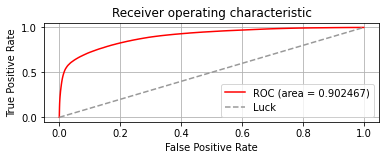


 Score =  0.800
 Signif =  1.40
 nsig = 124
 nbkg = 7876

FileName                                                          ConfusionMatrix [TP FP] [FN TN]   Run Time               AUC     Avg.P   Score   Max Signif nsig        nbkg       
 2021.02.18_11.29.10.numLayers3.numBranches75.batchSize512.CPU.h5  ([752562, 9142], [46045, 39251]) 0 days 00:17:33.168532  0.9025  0.6645   0.800   1.40             124        7876
Saving model.....
old auc: 
 0.9024670862391632 
 new auc 0.9025
Model Saved


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


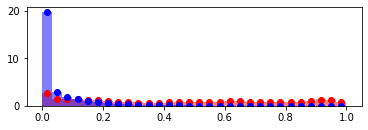

In [12]:
aucroc=checkTraining(model,kModel)
storeModel(model,startTime,modelName,aucroc)